In [1]:
import os
os.chdir("../")

import time

import random

import torch
from torchvision import transforms
import torchvision.models as models

from tqdm import tqdm

import matplotlib.pyplot as plt

from ingredients.dataset import get_dataset_loaders
from ingredients.utilities import set_seed

In [2]:
# ----------

config = {
    "seed": 1123,
    "dataset": "stl10",
    "n_samples": 0,
    "batch_size": 64,
    "num_epochs": 5,
    "preprocess_forward": True,
    "device": "cuda"
}

MODEL_FILENAME = f"resnet18.model_seed={config['seed']}.dataset={config['dataset']}.dataset_seed=1233.pth"

SAVE_MODEL_PATH = "./pretrained_models"
os.makedirs(SAVE_MODEL_PATH, exist_ok=True)

# ----------

In [3]:
set_seed(config["seed"])

device = torch.device(config["device"])

In [4]:
dataloaders = get_dataset_loaders(
    config["dataset"], config["batch_size"], config["n_samples"], config["seed"]
)

train_loader = dataloaders["train"]
test_loader = dataloaders["val"]

Loading STL10 dataset with batch size 64
Files already downloaded and verified
Files already downloaded and verified
whole length of the validation set is: 8000


In [5]:
# Load the pre-trained ResNet-34 model
resnet = models.resnet18(pretrained=True)

# Modify the last layer to output n classes
CLASS_NUM = 10

num_classes = CLASS_NUM
num_features = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_features, num_classes)

if config["preprocess_forward"]:
    torch_preprocess = transforms.Normalize(
                (0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)
            )

    # MONEKY PATCH FOR PREPROCESSING
    original_forward = resnet.forward

    def preprocess_forward(x, *args, **kwargs):
        x = torch_preprocess(x)
        return original_forward(x, *args, **kwargs)

    resnet.forward = preprocess_forward

resnet.to(device)

/home/lazzaro/miniconda3/envs/multishield/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lazzaro/miniconda3/envs/multishield/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

In [7]:
#validation function
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    for int, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
    
    return val_loss, val_accuracy

In [8]:
# training function
def train(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0##this is in train
    #for data in tqdm(train_dataloader):
    for data in tqdm(train_dataloader, desc="Training", bar_format="{l_bar}{bar:30}{r_bar}{bar:-30b}", leave=False, ncols=100, colour='green', position=0):
        
        #print(data)
        img, labels = data[0].to(device) , data[1].to(device)
        optimizer.zero_grad()#train
        output = model(img)
        loss = criterion(output, labels)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)

    #print('Train Loss: %.4f'%train_loss)
    
    return train_loss, train_accuracy

In [9]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()

NB_EPOCH = config["num_epochs"]


for epoch in range(NB_EPOCH):
    train_epoch_loss, train_epoch_accuracy = train(resnet, train_loader)
    val_epoch_loss, val_epoch_accuracy = validate(resnet, test_loader)
    print("Train Loss : %f/  Train Acc : %.2f/  Val Loss : %f/  Val Acc : %.2f"%(train_epoch_loss,train_epoch_accuracy,val_epoch_loss,val_epoch_accuracy))
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

    #print("Train Acc : %f"%train_accuracy,"Val Acc : %f"%val_accuracy)
    
end = time.time()

print(int((end-start)//60), 'minutes', int((end-start)%60), 'seconds')

Train Loss : 0.015957/  Train Acc : 73.54/  Val Loss : 0.004983/  Val Acc : 93.25


Train Loss : 0.003941/  Train Acc : 94.94/  Val Loss : 0.003273/  Val Acc : 94.54


Train Loss : 0.002338/  Train Acc : 97.40/  Val Loss : 0.002707/  Val Acc : 95.06


Train Loss : 0.001527/  Train Acc : 98.70/  Val Loss : 0.002454/  Val Acc : 95.16


Train Loss : 0.001048/  Train Acc : 99.40/  Val Loss : 0.002327/  Val Acc : 95.21
0 minutes 50 seconds


In [10]:
# ----------
# SAVE MODELS
# ----------

save_path = os.path.join(SAVE_MODEL_PATH, MODEL_FILENAME)

torch.save(resnet.state_dict(), save_path)

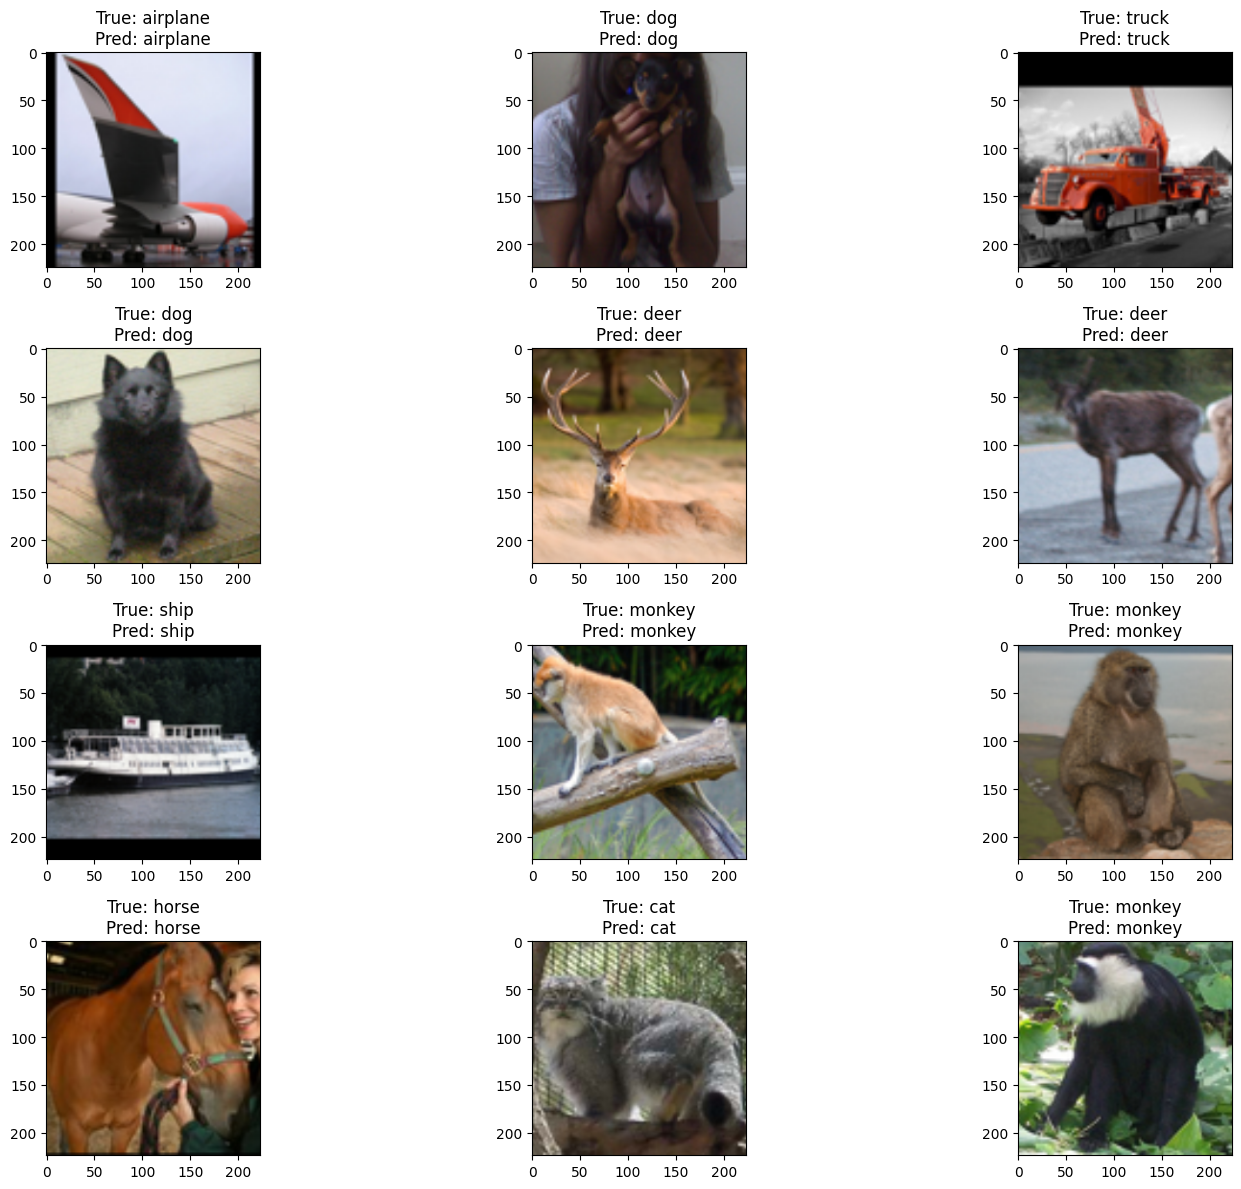

In [11]:
# ----------
# PLOT
# ----------

class_names = dataloaders["class_names"]

test_dataset = test_loader.dataset

ROW = 4
COL = 3

fig, axs = plt.subplots(nrows = ROW , ncols = COL, figsize=(ROW*4, COL*4))

for cnt in range(ROW*COL):
    i = random.randrange(0,len(test_dataset))
    img = test_dataset[i][0]
    label = class_names[test_dataset[i][1]]
    
    #Get predicted label
    with torch.no_grad():
        #Use Model
        img, _  = test_dataset[i]
        img = img.to(device)
        outputs = resnet(img.unsqueeze(0))
        
        #Get the predicted class labels for each images
        _ , pred_num = torch.max(outputs.data , dim = 1)
        
        pred_label = class_names[pred_num]
        
    axs[(cnt) // COL, (cnt) % COL].imshow(img.cpu().permute(1, 2, 0))
    axs[cnt // COL, cnt % COL].set_title(f"True: {label}\nPred: {pred_label}")
    
plt.tight_layout()
plt.show()